# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from ultralytics import YOLO
from PIL import Image

# Style Settings

In [3]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.4)  

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 14,          
    'axes.titlesize': 18,       
    'axes.labelsize': 16,       
    'xtick.labelsize': 14,     
    'ytick.labelsize': 14,      
    'axes.titlepad': 14,        
    'axes.labelpad': 10,        
    'legend.fontsize': 13,      
})

COLORS = {
    "light":   "#deebf7",
    "mid":     "#6baed6",
    "dark":    "#2171b5",
    "edge":    "#9ecae1",
    "heatmap": "#6baed6",
}

def apply_common_style(ax, grid_axis='y'):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.grid(axis=grid_axis, linestyle='--', alpha=0.6)
    ax.tick_params(labelsize=14)  
    return ax


# Predictions

In [ ]:
model = YOLO("best.pt")

image_folder = "Error Dataset/images"

predictions_list = []

for image_name in os.listdir(image_folder):
    if image_name.endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(image_folder, image_name)

        results = model(image_path, iou=0.0)

        image_id = os.path.splitext(image_name)[0]

        for result in results:
            for box in result.boxes.data.tolist():
                x_min, y_min, x_max, y_max, confidence, class_id = box

                predictions_list.append({
                    "image_id": image_id,
                    "x_min": x_min,
                    "y_min": y_min,
                    "x_max": x_max,
                    "y_max": y_max
                })

model_predictions = pd.DataFrame(predictions_list)

model_predictions.to_csv("model_predictions.csv", index=False)

print("Model predictions saved to model_predictions.csv")

# Input Data: Annotations, Misses, and Predictions

In [15]:
remaining_gt = pd.read_csv("radiologist_annotations.csv")
visual_misses = pd.read_csv("visual_misses.csv")
predictions = pd.read_csv("model_predictions.csv")

# Evaluation of RADAR Predictions Against Visual Misses

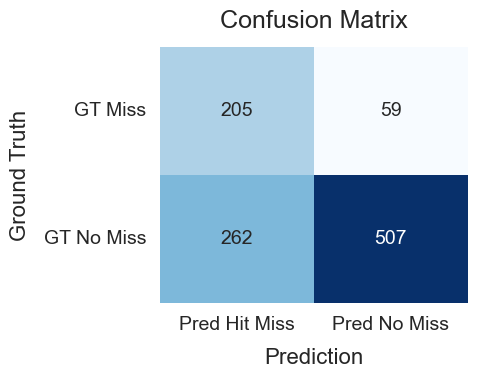

TP: 205, FP: 262, FN: 59, TN: 507
Precision: 0.439
Recall:    0.777
F1-score:  0.561
Accuracy:  0.689


In [7]:
IOU_THRESHOLD = 0.0

def compute_iou(b1, b2):
    x1_min, y1_min, x1_max, y1_max = b1
    x2_min, y2_min, x2_max, y2_max = b2
    ix_min = max(x1_min, x2_min)
    iy_min = max(y1_min, y2_min)
    ix_max = min(x1_max, x2_max)
    iy_max = min(y1_max, y2_max)
    inter  = max(0, ix_max - ix_min) * max(0, iy_max - iy_min)
    a1     = (x1_max - x1_min) * (y1_max - y1_min)
    a2     = (x2_max - x2_min) * (y2_max - y2_min)
    union  = a1 + a2 - inter
    return inter / union if union > 0 else 0

# Filter out preds overlapping remaining-GT

gt_dict = (
    remaining_gt
    .groupby("image_id")[["x_min","y_min","x_max","y_max"]]
    .apply(lambda df: [tuple(r) for r in df.values])
    .to_dict()
)

clean_preds = []
for _, row in predictions.iterrows():
    img      = row["image_id"]
    pred_box = (row["x_min"], row["y_min"], row["x_max"], row["y_max"])
    gt_boxes = gt_dict.get(img, [])
    if any(compute_iou(pred_box, gt) > 0 for gt in gt_boxes):
        continue
    clean_preds.append(row)

pred_df = pd.DataFrame(clean_preds).reset_index(drop=True)

# TP, FP, and FN
TP = 0
FP = 0
# check if prediciton hits visual miss box
for _, row in pred_df.iterrows():
    img      = row["image_id"]
    pbox     = (row["x_min"], row["y_min"], row["x_max"], row["y_max"])
    vm_boxes = visual_misses[visual_misses.image_id==img][["x_min","y_min","x_max","y_max"]].values
    if any(compute_iou(pbox, tuple(m)) > IOU_THRESHOLD for m in vm_boxes):
        TP += 1
    else:
        FP += 1

FN = 0
# Check if we missed a visual miss box
for _, row in visual_misses.iterrows():
    img   = row["image_id"]
    mbox  = (row["x_min"], row["y_min"], row["x_max"], row["y_max"])
    pboxes = pred_df[pred_df.image_id==img][["x_min","y_min","x_max","y_max"]].values
    if not any(compute_iou(mbox, tuple(p)) > IOU_THRESHOLD for p in pboxes):
        FN += 1

# Compute TN per image
all_images   = set(remaining_gt.image_id.unique())
miss_images  = set(visual_misses.image_id.unique())
pred_images  = set(pred_df.image_id.unique())

TN = sum(
    1
    for img in all_images
    if (img not in miss_images) and (img not in pred_images)
)

# Metrics and Confusion Matrix
conf = np.array([[TP, FN],
                 [FP, TN]])

plt.figure(figsize=(5,4))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred Hit Miss", "Pred No Miss"],
            yticklabels=["GT Miss",       "GT No Miss"])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

precision = TP / (TP + FP) if TP + FP else 0
recall    = TP / (TP + FN) if TP + FN else 0
f1_score  = 2 * precision * recall / (precision + recall) if precision + recall else 0
accuracy  = (TP + TN) / (TP + TN + FP + FN)

print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1_score:.3f}")
print(f"Accuracy:  {accuracy:.3f}")

# CDF of IoU Scores Between Model Predictions and Error

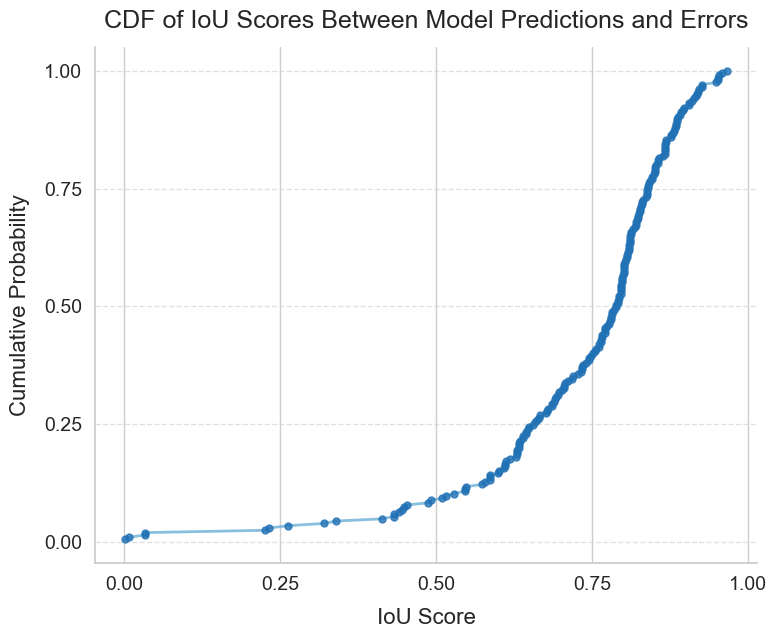

In [9]:
def compute_iou(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2
    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2)
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

gt_dict = (
    remaining_gt
    .groupby("image_id")[["x_min","y_min","x_max","y_max"]]
    .apply(lambda df: [tuple(r) for r in df.values])
    .to_dict()
)

clean_preds = []
for _, row in predictions.iterrows():
    img      = row["image_id"]
    pred_box = (row["x_min"], row["y_min"], row["x_max"], row["y_max"])
    gt_boxes = gt_dict.get(img, [])
    if any(compute_iou(pred_box, gt) > 0 for gt in gt_boxes):
        continue
    clean_preds.append(row)

model_predictions = pd.DataFrame(clean_preds).reset_index(drop=True)

iou_scores = []
for _, pred in model_predictions.iterrows():
    pred_box = (pred['x_min'], pred['y_min'], pred['x_max'], pred['y_max'])
    image_id = pred['image_id']
    for _, error in visual_misses[visual_misses['image_id'] == image_id].iterrows():
        error_box = (error['x_min'], error['y_min'], error['x_max'], error['y_max'])
        iou = compute_iou(pred_box, error_box)
        if iou > 0:
            iou_scores.append(iou)

sorted_iou = np.sort(iou_scores)
cdf = np.arange(1, len(sorted_iou) + 1) / len(sorted_iou)

fig, ax = plt.subplots(figsize=(8,6.6))
ax.plot(
    sorted_iou, cdf,
    color=COLORS["mid"],
    linestyle='-',
    linewidth=2,
    marker='o',
    markersize=5,
    markerfacecolor=COLORS["dark"],
    markeredgecolor=COLORS["dark"],
    alpha=0.8,
)

ax.set_xlabel('IoU Score')
ax.set_ylabel('Cumulative Probability')
ax.set_title('CDF of IoU Scores Between Model Predictions and Errors')

ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])

apply_common_style(ax)
plt.tight_layout()
plt.show()

# Box Plot of IoU Score Distribution

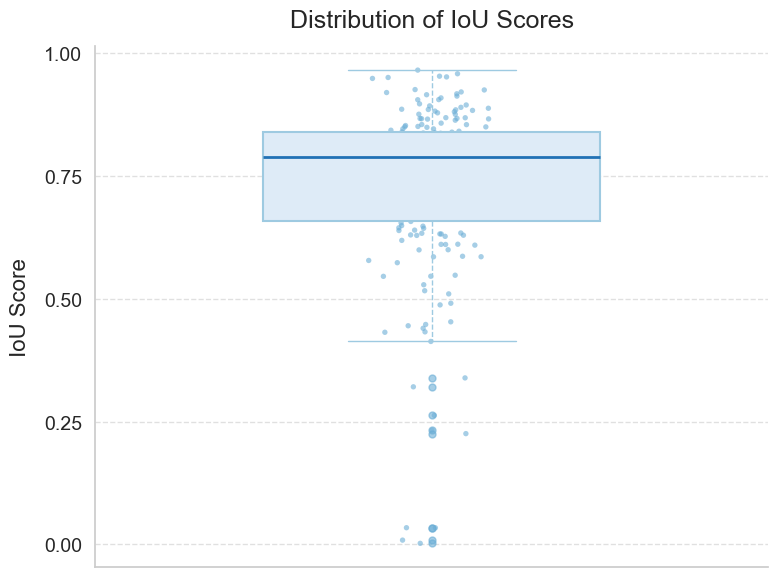

In [11]:
iou_scores = []

gt_dict = (
    remaining_gt
    .groupby("image_id")[["x_min","y_min","x_max","y_max"]]
    .apply(lambda df: [tuple(r) for r in df.values])
    .to_dict()
)

clean_preds = []
for _, row in predictions.iterrows():
    img      = row["image_id"]
    pred_box = (row["x_min"], row["y_min"], row["x_max"], row["y_max"])
    gt_boxes = gt_dict.get(img, [])
    if any(compute_iou(pred_box, gt) > 0 for gt in gt_boxes):
        continue
    clean_preds.append(row)

model_predictions = pd.DataFrame(clean_preds).reset_index(drop=True)


for _, pred in model_predictions.iterrows():
    pred_box = (pred['x_min'], pred['y_min'], pred['x_max'], pred['y_max'])
    image_id = pred['image_id']
    for _, error in visual_misses[visual_misses['image_id'] == image_id].iterrows():
        error_box = (error['x_min'], error['y_min'], error['x_max'], error['y_max'])
        iou = compute_iou(pred_box, error_box)
        if iou > 0:
            iou_scores.append(iou)

df = pd.DataFrame(iou_scores, columns=["IoU Score"])
scores = df["IoU Score"].values

df.to_csv("box_plot_iou_scores")

fig, ax = plt.subplots(figsize=(8,6))
box = ax.boxplot(
    scores,
    vert=True,
    patch_artist=True,
    widths=0.5,
    boxprops=dict(facecolor=COLORS["light"], edgecolor=COLORS["edge"], linewidth=1.5),
    whiskerprops=dict(color=COLORS["edge"], linestyle='--', linewidth=1),
    capprops=dict(color=COLORS["edge"], linewidth=1),
    medianprops=dict(color=COLORS["dark"], linewidth=2),
    flierprops=dict(
        marker="o",
        markerfacecolor=COLORS["mid"],
        markeredgecolor=COLORS["mid"],   # ← match the face
        markersize=5,
        alpha=0.6
    )
)

x = np.random.normal(1, 0.04, size=len(scores))
ax.scatter(
    x, scores,
    s=15,
    alpha=0.6,
    facecolors=COLORS["mid"],
    edgecolors='none',   # ← turn off the outline
    label="IoU values"
)
ax.set_title("Distribution of IoU Scores")
ax.set_ylabel("IoU Score")
ax.set_xticks([])

ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
apply_common_style(ax)
plt.tight_layout()
plt.show()